In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

### 1. data preprorcessing: prepare data for training & test sets

#### import dataset and data cleaning and selection 

The training dataset includes wind speeds of various altitude increments, in 10 minutes intervals, for a little more than 12 month. It includes horizontal wind speed, vertical wind speed, mean values, max and min values in the increments, standard deviations and other columns. 

There are certain unrealistic values for wind speeds suh as 9999 or 9998 or N/A, this is likely due to processing error in the technical instrumet.

Thus, for data cleaning, we will filter out the values above 50 as it is nearly impossible for wind speed in the given altitudes to exceed 50. And for data selection, we shall only use the columns that record the horizontal wind speeds as the HAWTs (Horizontal-Axis Wind Turbines) use the lift force of the horizontal winds to generate energy, and disregard the other data for now.  

In [4]:
file_path = "../Data/E05_Hudson_North_10_min_avg_20190812_20210919.csv"

data = pd.read_csv(file_path)

data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

sorted_data = data[data['timestamp'] <= pd.Timestamp('2021-08-12')]

sorted_data.head()

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_22384\1195850410.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,52,53,54,55,56,57,58,59,60,62,63,64,65,66,67,68,69,70,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,89,90,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2019-08-12 00:00:00,7.2923,0.5159,8.2792,6.0537,251.5426,0.1971,4.0,0.0,36.0,...,7.644,-6.274,6.088,-7.194,6.121,-6.098,13.03,39.9695,-72.716,E05
1,2019-08-12 00:10:00,7.8613,0.6321,9.1869,6.1966,245.2114,0.1425,4.0,0.0,37.0,...,7.205,-6.716,6.86,-8.25,6.024,-5.765,13.03,39.9694,-72.716,E05
2,2019-08-12 00:20:00,7.7594,0.635,9.0702,6.1366,246.7355,0.1568,4.0,0.0,37.0,...,6.416,-7.058,5.03,-7.563,5.344,-6.38,13.03,39.9695,-72.716,E05
3,2019-08-12 00:30:00,7.4891,0.4983,8.6377,6.5824,247.0218,0.0493,4.0,0.0,38.0,...,7.767,-7.505,5.555,-7.663,7.64,-8.3,13.03,39.9695,-72.716,E05
4,2019-08-12 00:40:00,7.8829,0.6361,9.4056,6.4107,244.106,0.0897,4.0,0.0,37.0,...,6.627,-6.468,7.694,-9.47,6.511,-7.137,13.02,39.9695,-72.716,E05


In [5]:
# Filtering columns with 'HorizWS' in their names
horiz_ws_columns = [col for col in data.columns if 'lidar_lidar18m_Z10_HorizWS' in col]
horiz_ws_data = data[horiz_ws_columns]

# Converting wind speed columns to numeric, setting errors='coerce' to turn non-numeric values into NaN
numeric_horiz_ws_data = horiz_ws_data.apply(pd.to_numeric, errors='coerce')

# Filtering out all values above 50
cleaned_numeric_horiz_ws_data = numeric_horiz_ws_data[numeric_horiz_ws_data <= 50].dropna()

# Displaying the first few rows of the cleaned numeric data
cleaned_numeric_horiz_ws_data.head()

,lidar_lidar18m_Z10_HorizWS
0,7.2923
1,7.8613
2,7.7594
3,7.4891
4,7.8829


In [6]:
len(cleaned_numeric_horiz_ws_data)

108510

In [7]:
points_in_two_years = 6 * 24 * 365 * 2

# Generate new index for interpolation
new_index = np.linspace(0, len(cleaned_numeric_horiz_ws_data) - 1, points_in_two_years)

# Interpolating the DataFrame
interpolated_data = np.interp(new_index, np.arange(len(cleaned_numeric_horiz_ws_data)), 
                              cleaned_numeric_horiz_ws_data.iloc[:, 0])

# Converting the interpolated array back to a DataFrame
cleaned_numeric_horiz_ws_data = pd.DataFrame(interpolated_data, columns=cleaned_numeric_horiz_ws_data.columns)

In [8]:
len(cleaned_numeric_horiz_ws_data)

105120

#### Data normalization

The data is normalized with MinMax (imported from the scikit-learn library) for MinMax scaling's ability to transform data into a bounded range while preserving temporal relationships. It is suitable for TimeGAN models like this one, which are designed to generate realistic time-series data.

In [9]:
# Initializing the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(cleaned_numeric_horiz_ws_data)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns=cleaned_numeric_horiz_ws_data.columns)

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar18m_Z10_HorizWS
0,0.261640
1,0.283437
2,0.278966
3,0.270691
4,0.283910


#### Reshaping the data

LSTM model is chosen to focus on seasonal variations between the relationship of a short input data and a longer output data

In [10]:
points_in_month = int(len(cleaned_numeric_horiz_ws_data) / (2 * 12))
points_in_month

4380

In [11]:
ratio = [1, 11]
forecast_ratio = int(ratio[1] / ratio[0])

In [12]:
input_sequence_length = points_in_month * ratio[0]
output_sequence_length = points_in_month * ratio[1]

In [13]:
def create_sequences(data, history_length, forecast_ratio):
    X, Y = [], []
    forecast_length = history_length * forecast_ratio
    total_sequence_length = history_length + forecast_length

    # Check if the total sequence length is longer than the data length
    if total_sequence_length > len(data):
        print("Total sequence length is greater than the data length. Adjusting the lengths.")
        # Adjust the lengths to fit the data
        forecast_length = len(data) - history_length
        total_sequence_length = len(data)

    for i in range(0, len(data) - total_sequence_length + 1, total_sequence_length):
        X.append(data[i:(i + history_length)])
        Y.append(data[(i + history_length):(i + total_sequence_length)])
    return np.array(X), np.array(Y)

# Assuming input_sequence_length is defined
X, Y = create_sequences(normalized_df, input_sequence_length, forecast_ratio)

# Splitting the data in half for training and testing
train_size = len(X) // 2
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (1, 4380, 1)
Y_train shape: (1, 48180, 1)
X_test shape: (1, 4380, 1)
Y_test shape: (1, 48180, 1)


#### Defining the LSTM model

The hyperparameters below are tuned from the keras tuner. It is hard coded here because when the code needs to be reran there wouldn't have to be a re-search of keras parameters.

In [12]:
n_neurons = 352
activation = "sigmoid"
num_epochs = 100
learning_rate = 0.00011974213314597185
minibatch_size = 64

In [13]:
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(input_sequence_length, 1), return_sequences=True, activation = activation))
model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(output_sequence_length))

# Model compilation
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 20, verbose = 1, restore_best_weights = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4380, 352)         498432    
                                                                 
 dropout (Dropout)           (None, 4380, 352)         0         
                                                                 
 lstm_1 (LSTM)               (None, 352)               992640    
                                                                 
 dropout_1 (Dropout)         (None, 352)               0         
                                                                 
 dense (Dense)               (None, 48180)             17007540  
                                                                 
Total params: 18498612 (70.57 MB)
Trainable params: 18498612 (70.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
history = model.fit(X_train, Y_train, epochs = num_epochs, batch_size = minibatch_size, validation_data=(X_test, Y_test), callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 16s 16s/step - loss: 0.1152 - val_loss: 0.0982
Epoch 2/100
1/1 [==============================] - 12s 12s/step - loss: 0.1048 - val_loss: 0.0772
Epoch 3/100
1/1 [==============================] - 13s 13s/step - loss: 0.0798 - val_loss: 0.0473
Epoch 4/100
1/1 [==============================] - 14s 14s/step - loss: 0.0425 - val_loss: 0.0298
Epoch 5/100
1/1 [==============================] - 13s 13s/step - loss: 0.0116 - val_loss: 0.0455
Epoch 6/100
1/1 [==============================] - 13s 13s/step - loss: 0.0102 - val_loss: 0.0686
Epoch 7/100
1/1 [==============================] - 13s 13s/step - loss: 0.0201 - val_loss: 0.0723
Epoch 8/100
1/1 [==============================] - 12s 12s/step - loss: 0.0141 - val_loss: 0.0660
Epoch 9/100
1/1 [==============================] - 12s 12s/step - loss: 0.0081 - val_loss: 0.0586
Epoch 10/100
1/1 [==============================] - 12s 12s/step - loss: 0.0040 - val_loss: 0.0536
Epoch 11/100
1/1 [=

In [15]:
def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)
model.save(os.path.join(model_path, 'LSTM_model_18m_interpolated.h5'))

c:\Users\Jiarong Xie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
model_path = os.path.join(os.getcwd(), 'saved_model', 'LSTM_model_18m_interpolated.h5')
lstm_model = load_model(model_path)

In [14]:
test_mse = lstm_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test MSE: {test_mse}")

Test MSE: 0.029831770807504654


In [18]:
y_pred = lstm_model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [19]:
y_pred = scaler.inverse_transform(y_pred)

num_samples, num_timesteps, num_features = Y_test.shape
Y_test_reshaped = Y_test.reshape(-1, num_features)  # Reshape to 2D
Y_test_inverse = scaler.inverse_transform(Y_test_reshaped)
Y_test_inverse_reshaped = Y_test_inverse.reshape(num_samples, num_timesteps, num_features)

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_28948\2636918146.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_28948\2636918146.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

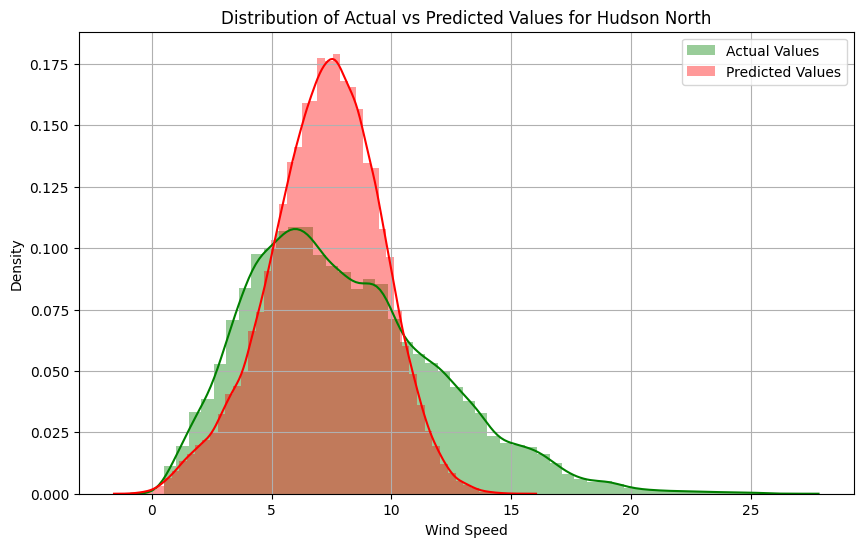

In [20]:
plt.figure(figsize=(10, 6))
#y_test_flat = Y_test.flatten()
y_pred_flat = y_pred.flatten()
y_test_flat = Y_test_inverse.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values for Hudson North')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

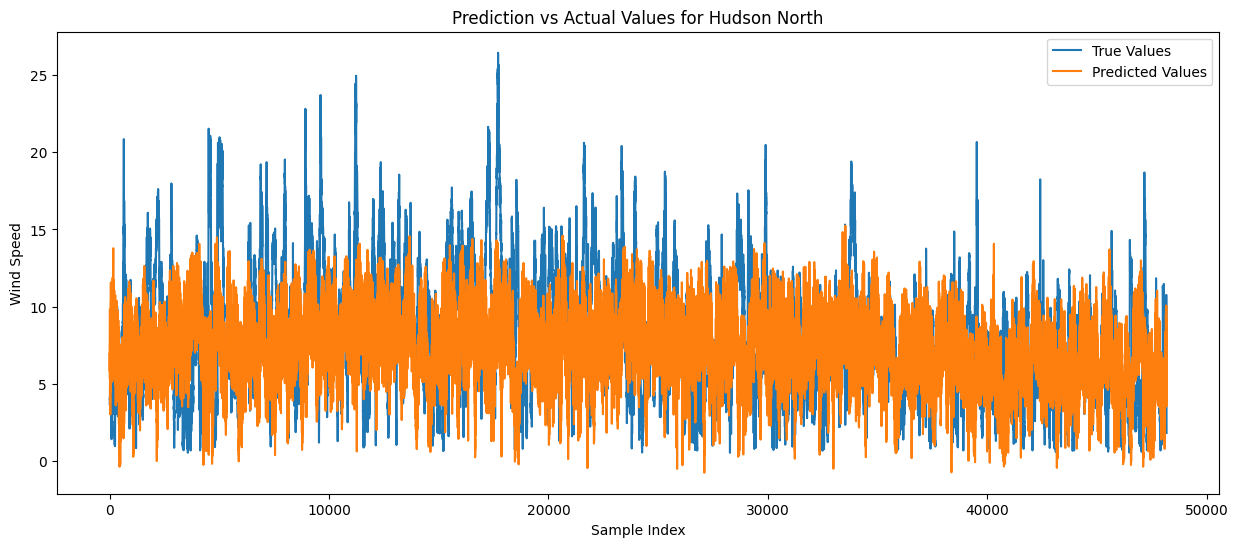

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values for Hudson North')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

#### Testing against a new dataset

In [42]:
file_path = "../Data/Wind Time Series Dataset(10min).csv"

new_data = pd.read_csv(file_path)

new_data['Time'] = pd.to_datetime(new_data['Time'])

new_data.head()

,Time,WindSpeed,Power
0,2014-10-07 01:20:00,8.22,40.526173
1,2014-10-07 01:30:00,8.09,38.552540
2,2014-10-07 01:50:00,7.21,21.313683
3,2014-10-07 02:00:00,6.75,18.031418
4,2014-10-07 02:10:00,6.52,16.593281


In [43]:
new_wind_speed = new_data["WindSpeed"]

new_wind_speed.head()

0    8.22
1    8.09
2    7.21
3    6.75
4    6.52
Name: WindSpeed, dtype: float64

In [44]:
len(new_wind_speed)

39195

In [45]:
points_in_year = 6 * 24 * 365

# Generate new index for interpolation
new_index = np.linspace(0, len(new_wind_speed) - 1, points_in_year)

# Interpolating the DataFrame
interpolated_data = np.interp(new_index, np.arange(len(cleaned_numeric_horiz_ws_data)), 
                              cleaned_numeric_horiz_ws_data.iloc[:, 0])

# Converting the interpolated array back to a DataFrame
new_wind_speed = pd.DataFrame(interpolated_data, columns=cleaned_numeric_horiz_ws_data.columns)

In [46]:
len(new_wind_speed)

52560

In [47]:
if len(new_wind_speed.shape) == 1:
    # Reshape the data to be 2D with one column
    new_wind_speed = new_wind_speed.values.reshape(-1, 1)

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(new_wind_speed)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns = ["WindSpeed"])

# Displaying the first few rows of the normalized data
normalized_df.head()

,WindSpeed
0,0.445563
1,0.466300
2,0.474594
3,0.475113
4,0.472769


In [55]:
def create_sequences(data, history_length, forecast_ratio):
    X, Y = [], []
    forecast_length = history_length * forecast_ratio
    total_sequence_length = history_length + forecast_length

    # Check if the total sequence length is longer than the data length
    if total_sequence_length > len(data):
        print("Total sequence length is greater than the data length. Adjusting the lengths.")
        # Adjust the lengths to fit the data
        forecast_length = len(data) - history_length
        total_sequence_length = len(data)

    for i in range(0, len(data) - total_sequence_length + 1, total_sequence_length):
        X.append(data[i:(i + history_length)])
        Y.append(data[(i + history_length):(i + total_sequence_length)])
    return np.array(X), np.array(Y)

X_test, Y_test = create_sequences(normalized_df, input_sequence_length, forecast_ratio)

# Print shapes to verify
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_test shape: (1, 4380, 1)
Y_test shape: (1, 48180, 1)


In [22]:
test_mse = lstm_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test MSE: {test_mse}")

Test MSE: 0.05545848235487938


In [29]:
y_pred = lstm_model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [30]:
y_pred = scaler.inverse_transform(y_pred)

num_samples, num_timesteps, num_features = Y_test.shape
Y_test_reshaped = Y_test.reshape(-1, num_features) 
Y_test_inverse = scaler.inverse_transform(Y_test_reshaped)
Y_test_inverse_reshaped = Y_test_inverse.reshape(num_samples, num_timesteps, num_features)

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_28948\1031757291.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_28948\1031757291.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

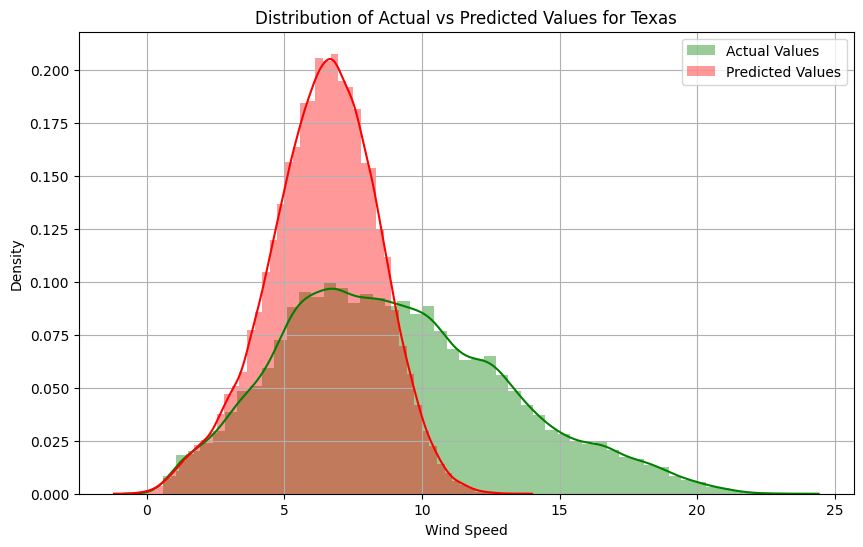

In [31]:
plt.figure(figsize=(10, 6))
#y_test_flat = Y_test.flatten()
y_pred_flat = y_pred.flatten()
y_test_flat = Y_test_inverse.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values for Texas')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

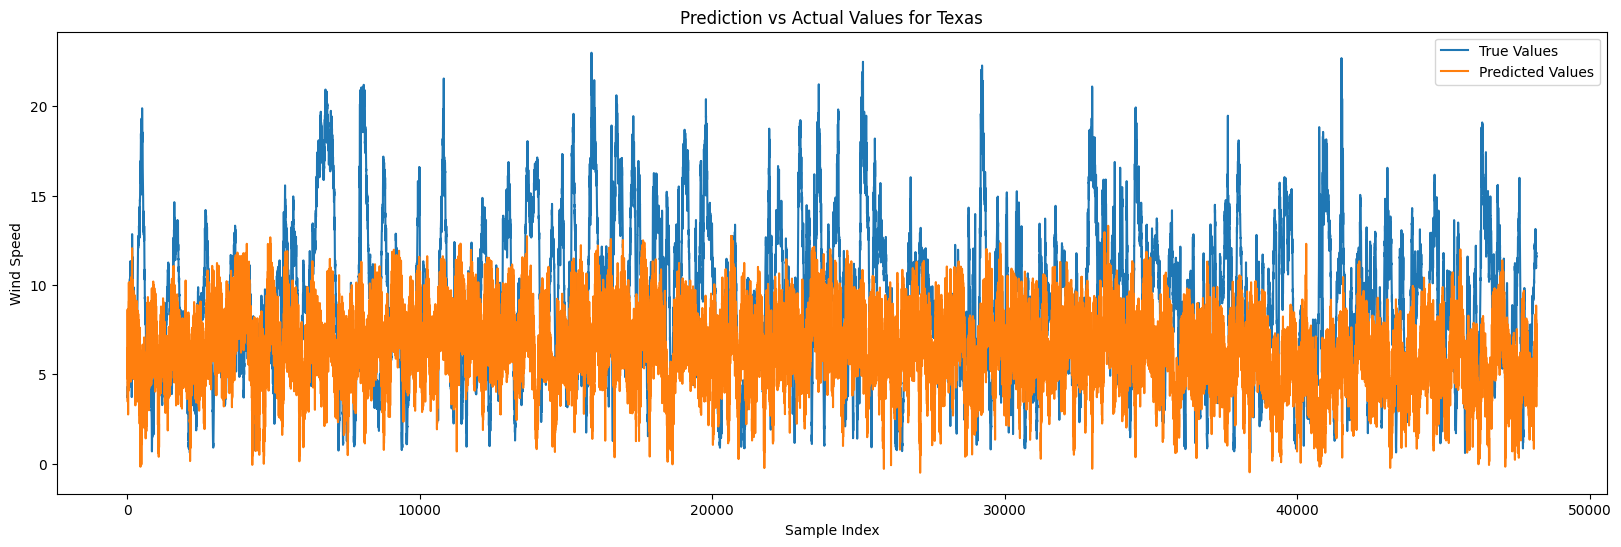

In [32]:
plt.figure(figsize=(20, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values for Texas')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

#### Different Starting Month

In [23]:
file_path = "../Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.xls"

data = pd.read_excel(file_path)

data = data.reset_index(drop=True)

data.head()

,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2022-01-29 00:00:00,10.4512,0.9643,13.4083,8.677,43.9618,0.2045,4,0,32,...,5.316,-7.165,5.282,-7.98,6.971,-6.687,12.97,39.4847,-73.5908,E05
1,2022-01-29 00:10:00,11.0738,0.8861,13.0669,9.1183,43.9564,0.3611,4,0,32,...,5.145,-6.437,5.686,-8.02,8.3,-7.213,12.97,39.4847,-73.5908,E05
2,2022-01-29 00:20:00,11.1295,1.0978,13.8472,8.8772,44.2444,0.2759,4,0,32,...,6.586,-8.72,6.736,-9.23,8.15,-8.99,12.97,39.4847,-73.5909,E05
3,2022-01-29 00:30:00,11.0591,1.0196,13.7819,9.2176,46.5821,0.1763,4,0,33,...,6.492,-7.805,8.22,-8.76,6.353,-8.91,12.97,39.4847,-73.5909,E05
4,2022-01-29 00:40:00,11.1425,0.8374,13.1432,9.2309,49.2058,0.3055,6,0,33,...,6.116,-7.546,6.578,-8.84,8.57,-10.83,12.97,39.4847,-73.5909,E05


In [24]:
# Filtering columns with 'HorizWS' in their names
horiz_ws_columns = [col for col in data.columns if 'lidar_lidar18m_Z10_HorizWS' in col]
horiz_ws_data = data[horiz_ws_columns]

# Converting wind speed columns to numeric, setting errors='coerce' to turn non-numeric values into NaN
numeric_horiz_ws_data = horiz_ws_data.apply(pd.to_numeric, errors='coerce')

# Filtering out all values above 50
cleaned_numeric_horiz_ws_data = numeric_horiz_ws_data[numeric_horiz_ws_data <= 50].dropna()

# Displaying the first few rows of the cleaned numeric data
cleaned_numeric_horiz_ws_data.head()

,lidar_lidar18m_Z10_HorizWS
0,10.4512
1,11.0738
2,11.1295
3,11.0591
4,11.1425


In [61]:
# Initializing the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(cleaned_numeric_horiz_ws_data)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns=cleaned_numeric_horiz_ws_data.columns)

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar18m_Z10_HorizWS
0,0.412018
1,0.437699
2,0.439996
3,0.437092
4,0.440532


In [62]:
len(normalized_df)

52093

In [63]:
# Generate new index for interpolation
new_index = np.linspace(0, len(normalized_df) - 1, points_in_year)

# Interpolating the DataFrame
interpolated_data = np.interp(new_index, np.arange(len(cleaned_numeric_horiz_ws_data)), 
                              cleaned_numeric_horiz_ws_data.iloc[:, 0])

# Converting the interpolated array back to a DataFrame
normalized_df = pd.DataFrame(interpolated_data, columns=cleaned_numeric_horiz_ws_data.columns)

In [64]:
if len(normalized_df.shape) == 1:
    # Reshape the data to be 2D with one column
    normalized_df = normalized_df.values.reshape(-1, 1)

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(normalized_df)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns = ["lidar_lidar18m_Z10_HorizWS"])

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar18m_Z10_HorizWS
0,0.423495
1,0.449929
2,0.452510
3,0.449617
4,0.452982


In [57]:
len(normalized_df)

52560

In [67]:
X_test, Y_test = create_sequences(normalized_df, input_sequence_length, forecast_ratio)

# Print shapes to verify
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_test shape: (1, 4380, 1)
Y_test shape: (1, 48180, 1)


In [68]:
test_mse = lstm_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test MSE: {test_mse}")

Test MSE: 0.03997459262609482


In [69]:
y_pred = lstm_model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [70]:
y_pred = scaler.inverse_transform(y_pred)

num_samples, num_timesteps, num_features = Y_test.shape
Y_test_reshaped = Y_test.reshape(-1, num_features)  # Reshape to 2D
Y_test_inverse = scaler.inverse_transform(Y_test_reshaped)
Y_test_inverse_reshaped = Y_test_inverse.reshape(num_samples, num_timesteps, num_features)

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_22384\3970557003.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_22384\3970557003.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

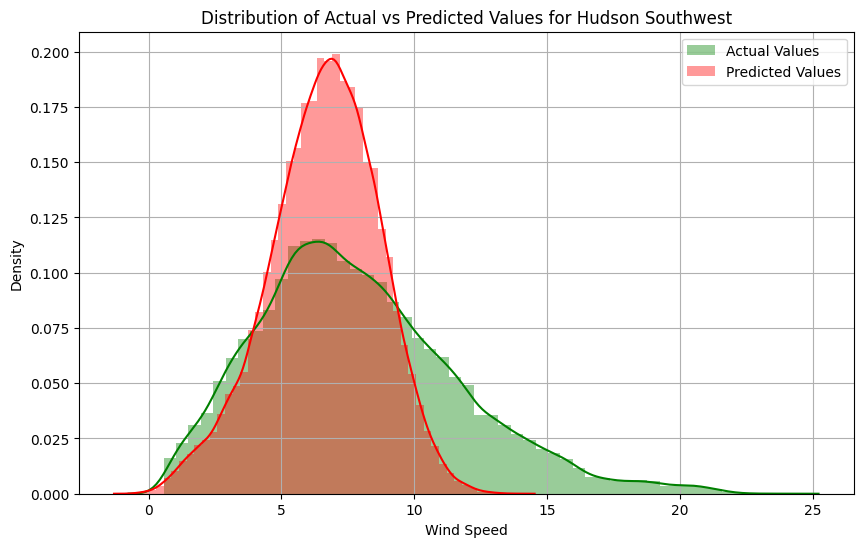

In [71]:
plt.figure(figsize=(10, 6))
#y_test_flat = Y_test.flatten()
y_pred_flat = y_pred.flatten()
y_test_flat = Y_test_inverse.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values for Hudson Southwest')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

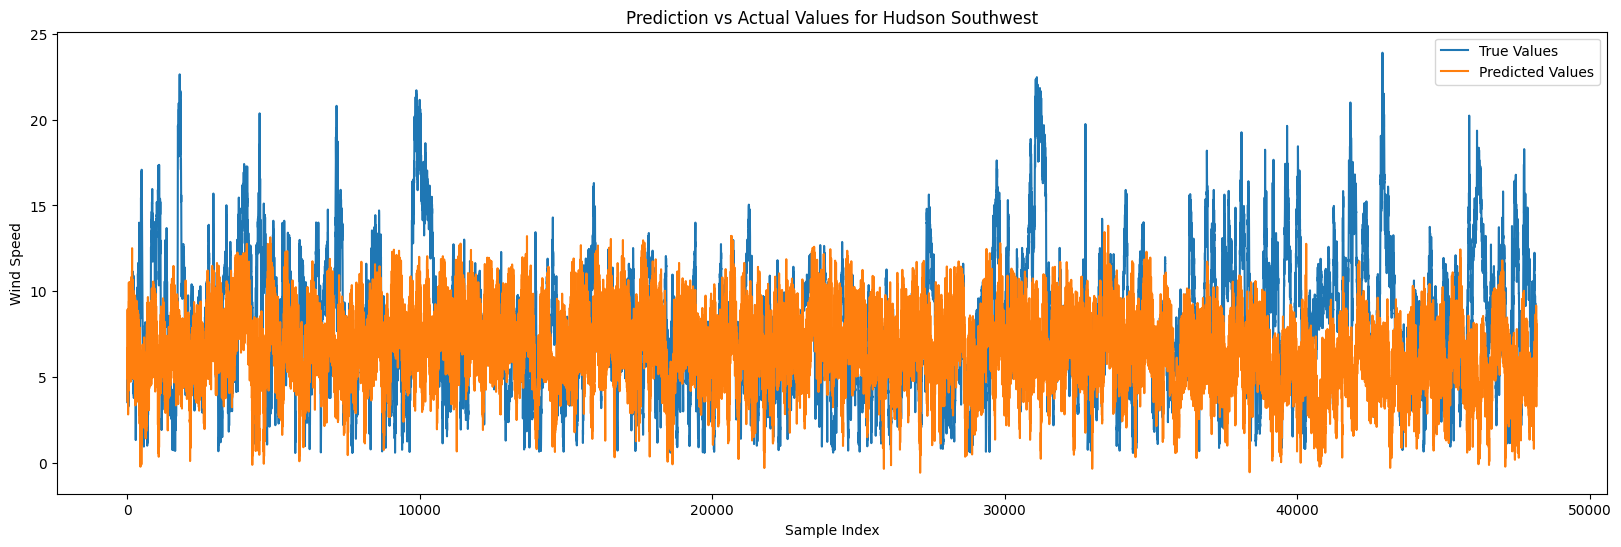

In [72]:
plt.figure(figsize=(20, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values for Hudson Southwest')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()